In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout,Dense,Flatten, BatchNormalization, Activation, \
     Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from tensorflow.keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adagrad
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img,array_to_img, ImageDataGenerator
from PIL import Image
#from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Input, Model
from imgaug import augmenters as iaa
import imgaug as ia
from glob import glob
from random import shuffle
import matplotlib.pyplot as plt
import cv2

# Pre-Processing

In [4]:
#Getting files from server
train_dir = os.path.join('../input/histopathologic-cancer-detection/train')
test_dir = os.path.join('../input/histopathologic-cancer-detection/test')
train_len = len(os.listdir(train_dir))  #Total test files
test_len = len(os.listdir(test_dir))  #Total test files
print('total training lymph node images:', len(os.listdir(train_dir)))
print('total testing lymph node images:', len(os.listdir(test_dir)))

total training lymph node images: 220025
total testing lymph node images: 57458


In [5]:
#Dataframe for image labels
traindf = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
def append_ext(fn):
    return fn+".tif"

traindf["id"] = traindf["id"].apply(append_ext)
traindf

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576.tif,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2.tif,0


In [8]:
#dividing files into train and test
labeled_files_train = glob(train_dir+'/*.tif')
labeled_files_test = glob(test_dir+'/*.tif')
train, valid = train_test_split(labeled_files_train, test_size=0.1, random_state=101010)

In [7]:
#Getting unlabeled data for pseudo labeling
valid, unlabled = train_test_split(valid, test_size=0.5, random_state=101010)

In [9]:
#Doing augmentation of image for reducing overfitting

def augment():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_de

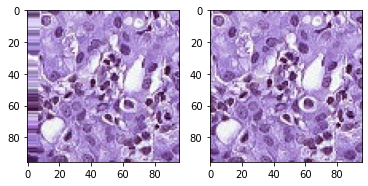

In [10]:
#Augmented image and original side by side
im = cv2.imread('../input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')
seq = augment()
im = im.reshape((1,96,96,3))
x = seq.augment_images(im)
x = x.reshape((96,96,3))
im = im.reshape((96,96,3))
_, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(x)
ax2.imshow(im)

In [32]:
#Helper function to get labels corresponding to image
id_label_map = {k:v for k,v in zip(traindf.id.values, traindf.label.values)}

#Function to break dataset into batches
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

#Generator for getting numpy array of image and labels 
def data_gen(labeled_files, id_label_map, batch_size, aug=False):
    seq = augment()
    while True:
        shuffle(labeled_files)
        for batch in chunker(labeled_files, batch_size):
            X = [cv2.resize(cv2.imread(x), (224,224)) for x in batch]
            Y = [id_label_map[os.path.basename(x)] for x in batch]
            if aug:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]
            
            yield np.array(X), np.array(Y)

# Models

***Custom Model***

In [12]:
input_shape = (96, 96, 3)

inputs = Input(input_shape)

conv_1 = Conv2D(64, 5, padding='same')(inputs)
batch_1 = BatchNormalization()(conv_1)
acti_1 = Activation('relu')(batch_1)

max_1 = MaxPool2D((2,2))(acti_1)

conv_2 = Conv2D(128, 5, padding='same')(max_1)
batch_2 = BatchNormalization()(conv_2)
acti_2 = Activation('relu')(batch_2)

max_2 = MaxPool2D((2,2))(acti_2)

conv_3 = Conv2D(264, 5, padding='same')(max_2)
batch_3 = BatchNormalization()(conv_3)
acti_3 = Activation('relu')(batch_3)

max_3 = MaxPool2D((2,2))(acti_3)

conv_4 = Conv2D(512, 5, padding='same')(max_3)
batch_4 = BatchNormalization()(conv_4)
acti_4 = Activation('relu')(batch_4)

max_4 = MaxPool2D((2,2))(acti_4)

flat = Flatten()(max_4)

dense_1 = Dense(256,activation='relu')(flat)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(1, activation='sigmoid')(dense_2)

model = Model(inputs=inputs, outputs=output)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 128)       512   

***NasNet Model*** 

In [13]:
inputs = Input((224, 224, 3))
base_model = NASNetMobile(include_top=False, input_shape=(224, 224, 3))#, weights=None
x = base_model(inputs)
out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)
out3 = Flatten()(x)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.5)(out)
out = Dense(1, activation="sigmoid", name="3_")(out)
model = Model(inputs, out)
model.compile(loss = 'binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

19996672/19993432 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
NASNet (Functional)             (None, 7, 7, 1056)   4269716     input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 1056)         0           NASNet[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1056)         0           NASNet[0][0]                     
___________________________

***InceptionV3 Model***

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16

pre_trained_model = InceptionV3(input_shape=(224, 224, 3),include_top=False)
for layer in pre_trained_model.layers:
    layer.trainable=False
last_layer=pre_trained_model.get_layer('mixed7')
output_layer=last_layer.output
x=Flatten()(output_layer)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)
model=Model(pre_trained_model.input,x)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 111, 111, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_192 (Activation)     (None, 111, 111, 32) 0           batch_normalization_4[0][0]      
___________________________

***DenseNet Model***

In [15]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
inputTensor = Input((224,224,3))
model_DenseNet201 = DenseNet201(include_top=False,input_shape = (224,224,3), weights='imagenet')
x = model_DenseNet201(inputTensor)
out1 = GlobalAveragePooling2D()(x)
out2 = GlobalMaxPooling2D()(x)
out = Concatenate(axis=-1)([out1, out2])
out = BatchNormalization()(out)
out = Dropout(0.6)(out)
out = Dense(1, activation="sigmoid")(out)
model = Model(inputTensor,out)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet201 (Functional)        (None, 7, 7, 1920)   18321984    input_5[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1920)         0           densenet201[0][0]                
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1920)         0           densenet201[0][0]                
___________________________

# One Cycle Policy

In [16]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class

from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import *
import keras

class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())
            

# Loading model weights and training model

In [ ]:
#Loading model weights 
model.load_weights("../input/model-weights/DenseNet_Model.h5")

In [ ]:
# Define Ony Cycle Policy parameters 
########################################################################################
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# CLR parameters

batch_size = 64
epochs = 10
max_lr = 0.0005
base_lr = max_lr/10
max_m = 0.98
base_m = 0.85

cyclical_momentum = True
augment = True
cycles = 2.35

iterations = round(len(train_list)/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)


model.compile(loss='binary_crossentropy', optimizer=SGD(0.0000001), metrics=['accuracy'])

clr =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)

In [ ]:
#Training models
batch_size = 32
train_steps = int(np.ceil(len(train)/batch_size))
val_steps = int(np.ceil(len(valid)/batch_size))
h5_path = "model.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = 0
with tf.device('/GPU:0'):
    history = model.fit(data_gen(train, id_label_map, batch_size,True), epochs=6, steps_per_epoch=train_steps, validation_data = data_gen(valid, id_label_map, batch_size), validation_steps=val_steps, callbacks=[checkpoint])

# Pseudo Labeling

In [ ]:
#Function to get numpy array of unlabeled images
def test_gen(labeled_files, batch_size=32, aug=False):

    while True:
        shuffle(labeled_files)
        df = pd.DataFrame(data=labeled_files, columns=['id'])
    
        for batch in chunker(labeled_files, batch_size):
            X = [cv2.resize(cv2.imread(x), (224,224)) for x in labeled_files]
            X = [preprocess_input(x) for x in X]
    
            yield np.array(X), df
            
pred, df = test_gen(unlabled)
#model.predict(test_gen(labeled_files_test, 32))
pred

In [ ]:
#Getting id and predicted label of unlabeled dataset in a dataframe
l = []
for i in df.id:
    l.append(os.path.basename(i))
df['id'] = l

labels = model.predict(test_gen(unlabled))
df['label'] = labels

#Taking only confident predictions
pseudo_data1=df.loc[df['label']>0.9]
pseudo_data1['label']=1
pseudo_data2=df.loc[df['label']<0.1]
pseudo_data2['label']=0
pseudo_data=pd.concat([pseudo_data1,pseudo_data2],axis=0)
pseudo_data=pseudo_data.sample(frac=1)
pseudo_data

In [ ]:
#Getting a dictionary for mapping id to label values
aug_traindf = traindf.copy()
aug_traindf.loc[pseudo_data.index, 'label'] = pseudo_data.label

id_label_map = {k:v for k,v in zip(aug_traindf.id.values, aug_traindf.label.values)}

In [ ]:
#Splitting pseudo data and adding to train and valid data
pseudo_train,pseudo_valid = train_test_split(pseudo_data, test_size=0.2, random_state=0)
aug_train = train + list(train_dir+"/"+pseudo_train.id)
aug_valid = valid + list(train_dir+"/"+pseudo_valid.id)

In [ ]:
#Trainging with pseudo labeling
batch_size = 32
train_steps = int(np.ceil(len(aug_train)/batch_size))
val_steps = int(np.ceil(len(aug_valid)/batch_size))
history1 = model.fit(data_gen(aug_train, id_label_map, batch_size,True), epochs=10, steps_per_epoch=train_steps, validation_data = data_gen(aug_valid, id_label_map, batch_size), validation_steps=val_steps)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Plot Learning Rate
import matplotlib.pyplot as plt
plt.plot(history.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

In [ ]:
# Plot momentum
import matplotlib.pyplot as plt
plt.plot(history.history['iterations'], clr.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()

In [36]:
preds = []
ids = []
batch_size = 32
#Calculating test prediction in batches and doing test time augmentation
for batch in chunker(valid, batch_size):
    X = [preprocess_input(cv2.imread(x)) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    preds += preds_batch
    ids += ids_batch
    
df = pd.DataFrame({'id':ids, 'label':preds})
df["id"] = df["id"].apply(append_ext)

In [38]:
temp = traindf[traindf['id'].isin(df.id)]
true = temp.sort_values('id').label.values
pred = df.sort_values('id').label.values

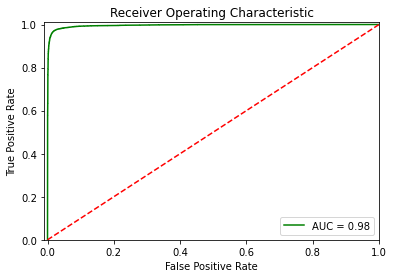

In [42]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(true, pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
import itertools

cm = confusion_matrix(true,np.round(pred))

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[12920   152]
 [  400  8531]]


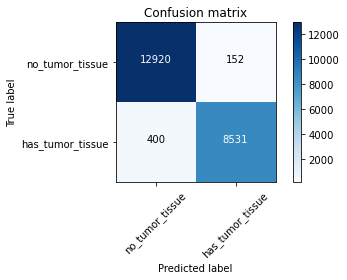

In [45]:
plot_confusion_matrix(cm,['no_tumor_tissue', 'has_tumor_tissue'])

# Getting predictions for test set

In [25]:
#Function to remove file extension from name to save to csv file
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')
preds = []
ids = []
batch_size = 32

In [ ]:
#Calculating test prediction in batches and doing test time augmentation
for batch in chunker(labeled_files_test, batch_size):
    X = [preprocess_input(cv2.resize(cv2.imread(x), (224,224))) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    preds += preds_batch
    ids += ids_batch

In [ ]:
# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
    # convert image into dataset
    samples = expand_dims(image, 0)
    # prepare iterator
    it = datagen.flow(samples, batch_size=n_examples)
    # make predictions for each augmented image
    yhats = model.predict_generator(it, steps=n_examples, verbose=0)
    # sum across predictions
    summed = numpy.sum(yhats, axis=0)
    # argmax across classes
    return argmax(summed)
 
# evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
    # configure image data augmentation
    datagen = ImageDataGenerator(horizontal_flip=True)
    # define the number of augmented images to generate per test set image
    n_examples_per_image = 7
    yhats = list()
    for i in range(len(testX)):
        # make augmented prediction
        yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
        # store for evaluation
        yhats.append(yhat)
    # calculate accuracy
    testY_labels = argmax(testY, axis=1)

    return testY_labels

In [ ]:
preds = tta_evaluate_model(model, labeled_files_test)

In [ ]:
#Creating dataframe for submission
df = pd.DataFrame({'id':ids, 'label':preds})
df.to_csv("submission5.csv", index=False)
df.head()